In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: LICENSE.txt             
  inflating: Testing_set_flower.csv  
  inflating: sample_submission.csv   
  inflating: test/Image_1.jpg        
  inflating: test/Image_10.jpg       
  inflating: test/Image_100.jpg      
  inflating: test/Image_101.jpg      
  inflating: test/Image_102.jpg      
  inflating: test/Image_103.jpg      
  inflating: test/Image_104.jpg      
  inflating: test/Image_105.jpg      
  inflating: test/Image_106.jpg      
  inflating: test/Image_107.jpg      
  inflating: test/Image_108.jpg      
  inflating: test/Image_109.jpg      
  inflating: test/Image_11.jpg       
  inflating: test/Image_110.jpg      
  inflating: test/Image_111.jpg      
  inflating: test/Image_112.jpg      
  inflating: test/Image_113.jpg      
  inflating: test/Image_114.jpg      
  inflating: test/Image_115.jpg      
  inflating: test/Image_116.jpg      
  inflating: test/Image_117.jpg      
  inflating: test/Image_118.jpg      
  inflating: test/I

In [10]:
DATADIR= "/content/Flowers"
CATEGORIES=["daisy","dandelion","rose","sunflower","tulip"]

In [92]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetV2B0,EfficientNetB0
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img,save_img
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
import seaborn as sns


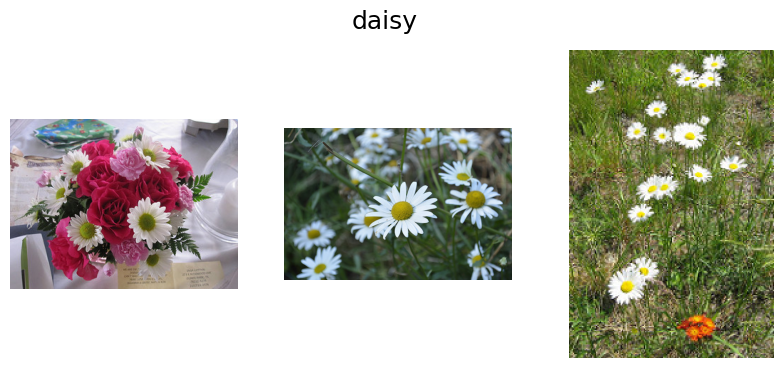

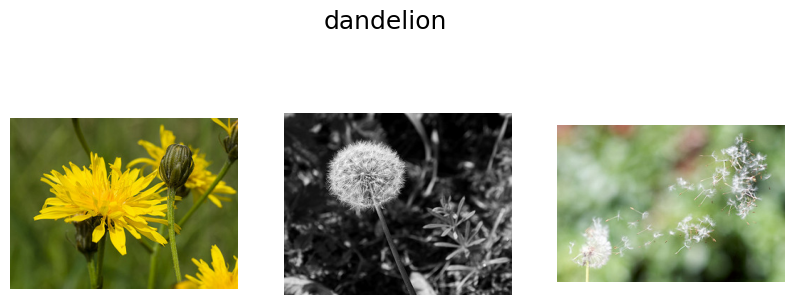

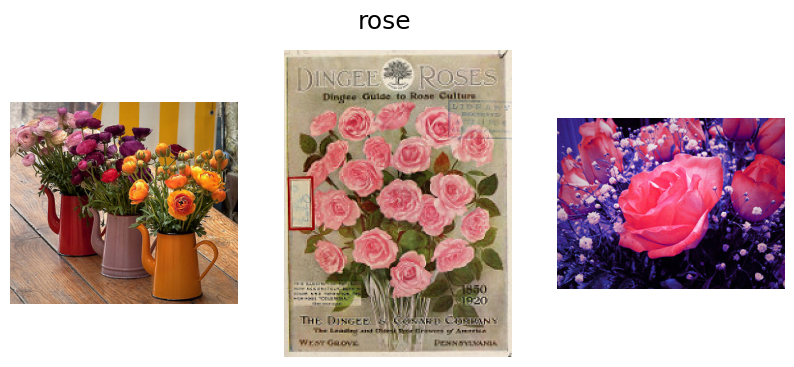

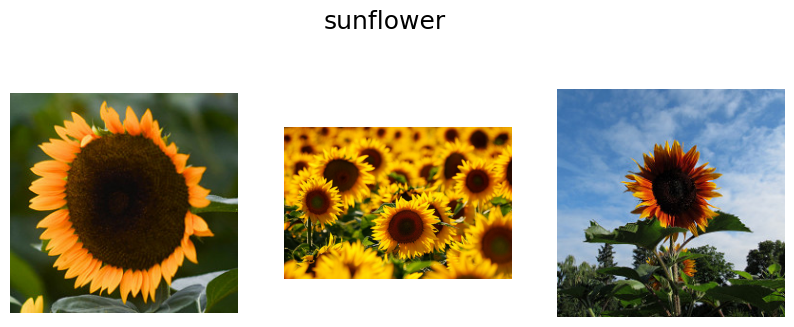

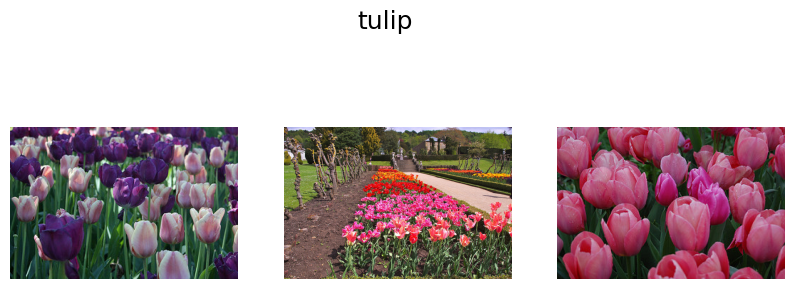

In [12]:
for category in CATEGORIES:
  path=os.path.join(DATADIR,category)
  images=os.listdir(path)
  fig, ax = plt.subplots(1, 3, figsize = (10, 4))
  fig.suptitle(f'{category}', fontsize = 18)

  for i in range(3):
    img_name=images[np.random.randint(0,len(images))]
    img_path=os.path.join(path,img_name)
    img_array=cv2.imread(img_path)
    img_rgb=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_rgb)
    ax[i].axis('off')

In [13]:
def count_imgs(directory):
  for category in CATEGORIES:
    img_dir=os.path.join(directory,category)
    images=os.listdir(img_dir)
    print(f'{category}: {len(images)}')

In [14]:
count_imgs(DATADIR)

daisy: 501
dandelion: 646
rose: 497
sunflower: 495
tulip: 607


In [15]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

def augment_images(directory, CATEGORIES):
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = np.expand_dims(img, axis=0)  # shape becomes (1, h, w, c)
            augmented_iter = data_gen.flow(img, batch_size=1)
            augmented_img = next(augmented_iter)[0].astype(np.uint8)

            new_filename = os.path.splitext(filename)[0] + '_augmented' + os.path.splitext(filename)[1]
            cv2.imwrite(os.path.join(path, new_filename), cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))


In [16]:
augment_images(DATADIR,CATEGORIES)

In [17]:
count_imgs(DATADIR)

daisy: 1002
dandelion: 1292
rose: 994
sunflower: 990
tulip: 1214


In [42]:
complete_data=[]
def create_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (224, 224))
        complete_data.append([new_array, labels])
      except Exception as e:
        pass

In [43]:
create_data()

In [44]:
X=[]
y=[]

for features,label in complete_data:
  X.append(features)
  y.append(label)

In [46]:
X = np.array(X).reshape(-1, 224, 224, 3)
y = np.array(y)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
len(X_test)

1099

In [57]:
er=EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
mc=ModelCheckpoint(
    filepath='tf_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='min'
)
cbs=[er,mc,lr]

In [65]:
base_model=EfficientNetV2B0(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [66]:
for layer in base_model.layers:
  layer.trainable=False

In [67]:
input=Input((224,224,3))

In [68]:
x=base_model(input,training=False)
x=(GlobalAveragePooling2D())(x)
x=(Dense(1024,activation='relu'))(x)
x=(Dense(512,activation='relu'))(x)
output=(Dense(5,activation='softmax'))(x)

In [69]:
tf_model=Model(input,output)

In [70]:
tf_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [71]:
tf_model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=cbs)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8132 - loss: 0.4979
Epoch 1: val_loss improved from inf to 0.18163, saving model to tf_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8137 - loss: 0.4968 - val_accuracy: 0.9299 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9615 - loss: 0.1200
Epoch 2: val_loss improved from 0.18163 to 0.17984, saving model to tf_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9615 - loss: 0.1200 - val_accuracy: 0.9418 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9687 - loss: 0.0861
Epoch 3: val_loss did not improve from 0.17984
138/138 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9688 - loss: 0.0861 - val_accuracy: 0.9454 - val_loss: 0.1801 - learning_rate: 0.0010
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9723 - loss: 0.0816
Epoch 4: val_loss improve

In [72]:
val_data=ImageDataGenerator(rescale=1/255).flow_from_directory(
    directory='/content/test',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)

Found 0 images belonging to 0 classes.


In [75]:
loss,accuracy=tf_model.evaluate(X_test,y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9756 - loss: 0.1002


In [82]:
y_pred=np.argmax(tf_model.predict(X_test),axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


In [83]:
y_pred

array([4, 0, 2, ..., 0, 1, 4])

In [87]:
pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1,2,3,4
0,205,6,2,1,0
1,1,255,0,0,0
2,0,0,178,0,4
3,4,2,0,181,0
4,1,1,7,2,249


In [93]:
accuracy_score(y_test,y_pred)

0.9717925386715196

In [94]:
f1_score(y_test,y_pred,average='weighted')

0.9717682715739425